 # Learning about network behavior with Mahi-Mahi
 
 ## Summary
 
[mahimahi](http://mahimahi.mit.edu/) is a tool that allows network protocol developers to test different network conditions on a single machine. It comes with a bunch of options to spin up lightweight network containers that have links with different qualities. For instance, if you want to to test a link with a particular network delay, bandwidth, or queue size, you can do that quite easily.
 
This jupyter notebook uses mahimahi to demonstrate how network traffic operates under different conditions.
 
The logic behind the setup here was inspired by work done in developing [indigo](https://github.com/StanfordSNR/indigo/tree/master/env), a reinforcement learning-based congestion control algorithm.
 
 ## Installation
 
 I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using [Vagrant](https://www.vagrantup.com) to spin up a VM.
 
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install jupyter

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```
 
 ## Usage
 
Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10)
```

The `run_with_mahi_settings` function takes some settings, notably a `delay`, `queue_size`, and `trace_file`, along with a number of seconds that it should run for, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those
network conditions.

 
 ## More Details
 
 ### Trace Files
 
 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)
 
 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:
 
 ```
 1
 2
 3
 4
 ...
 ```
 
 ## TODO

I will be adding implementations of different congestion control algorithms here and comparing how each of them
does under different networking conditions.


In [1]:
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from subprocess import Popen
from typing import Dict
from typing import List
from threading import Thread

In [2]:
RECEIVER_FILE = "run_receiver.py"

In [3]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

In [4]:
# Helper methods

def generate_mahimahi_command(mahimahi_settings: Dict):
    if mahimahi_settings.get('loss'):
        loss_directive = "mm-loss downlink %f" % mahimahi_settings.get('loss')
    else:
        loss_directive = ""
    return "mm-delay {delay} {loss_directive} mm-link traces/{trace_file} traces/{trace_file} --downlink-queue=droptail --downlink-queue-args=packets={queue_size}".format(
      delay=mahimahi_settings['delay'],
      queue_size=mahimahi_settings['queue_size'],
      loss_directive=loss_directive,
      trace_file=mahimahi_settings['trace_file']
    )
        
def get_open_udp_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)

    s.bind(('', 0))
    port = s.getsockname()[1]
    s.close()
    return port

        
def print_performance(sender, num_seconds: int):
    print("Results for sender %d:" % sender.port)
    print("Total Acks: %d" % sender.total_acks)
    print("Num Duplicate Acks: %d" % sender.num_duplicate_acks)
    print("%% duplicate acks: %f" % ((float(sender.num_duplicate_acks * 100))/sender.total_acks))
    print("Total bytes sent: %d" % sender.sent_bytes)
    print("Throughput (bytes/s): %f" % (sender.sent_bytes/num_seconds))
    print("Average RTT (ms): %f" % ((float(sum(sender.rtts))/len(sender.rtts)) * 1000))
    
    timestamps = [ ack[0] for ack in sender.times_of_acknowledgements]
    seq_nums = [ ack[1] for ack in sender.times_of_acknowledgements]

    plt.scatter(timestamps, seq_nums)
    plt.xlabel("Timestamps")
    plt.ylabel("Sequence Numbers")

    plt.show()
    
    plt.plot(sender.cwnds)
    plt.xlabel("Time")
    plt.ylabel("Congestion Window Size")
    plt.show()
    print("")


In [5]:
READ_FLAGS = select.POLLIN | select.POLLPRI
WRITE_FLAGS = select.POLLOUT
ERR_FLAGS = select.POLLERR | select.POLLHUP | select.POLLNVAL
READ_ERR_FLAGS = READ_FLAGS | ERR_FLAGS
ALL_FLAGS = READ_FLAGS | WRITE_FLAGS | ERR_FLAGS

In [6]:
class Sender(object):
    def __init__(self, port: int) -> None:
        self.port = port
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.sock.bind(('0.0.0.0', port))
        self.poller = select.poll()
        self.poller.register(self.sock, ALL_FLAGS)
        self.poller.modify(self.sock, ALL_FLAGS)
        self.peer_addr = None
        
        # Congestion control variables
        self.seq_num = 0
        self.next_ack = 0

        # Variables for the reinforment learning
        self.sent_bytes = 0

        self.min_rtt = float('inf')
        
        self.unacknowledged_packets = {}
        self.rtts = []
        self.start_time = time.time()
        self.total_acks = 0
        self.num_duplicate_acks = 0
        self.curr_duplicate_acks = 0
        self.cwnds = []
        # List of tuples of ack_time and seq_num
        self.times_of_acknowledgements = []
        
        
        if self.cwnd == None:
            raise "No initial setting for cwnd"
        
    def window_is_open(self):
        # Returns true if the congestion window is not full
        return self.seq_num - self.next_ack < self.cwnd

    def send(self):
        raise NotImplementedError
    
    def recv(self):
        raise NotImplementedError


    def handshake(self):
        """Handshake to establish connection with receiver."""

        while True:
            msg, addr = self.sock.recvfrom(1600)
            parsed_handshake = json.loads(msg.decode())
            if parsed_handshake.get('handshake') and self.peer_addr is None:
                self.peer_addr = addr
                self.sock.sendto(json.dumps({'handshake': True}).encode(), self.peer_addr)
                print('[sender] Connected to receiver: %s:%s\n' % addr)
                break
        self.sock.setblocking(0)

    def run(self, seconds_to_run: int):
        curr_flags = ALL_FLAGS
        TIMEOUT = 1000  # ms
        start_time = time.time()

        while time.time() - start_time < seconds_to_run:

            events = self.poller.poll(TIMEOUT)
            if not events:
                self.send()
            for fd, flag in events:
                assert self.sock.fileno() == fd

                if flag & ERR_FLAGS:
                    sys.exit('Error occurred to the channel')

                if flag & READ_FLAGS:
                    self.recv()

                if flag & WRITE_FLAGS:
                    if self.window_is_open():
                        self.send()


In [7]:
class FixedWindowSender(Sender):
    def __init__(self, cwnd: int, port: int) -> None:
        self.cwnd = cwnd
                
        super().__init__(port)


    def send(self):
        serialized_data = json.dumps({
            'seq_num': self.seq_num,
            'send_ts': time.time(),
            'sent_bytes': self.sent_bytes
        })
        self.unacknowledged_packets[self.seq_num] = True
        self.seq_num += 1
        self.sock.sendto(serialized_data.encode(), self.peer_addr)
        time.sleep(0)
    
    def recv(self):
        serialized_ack, addr = self.sock.recvfrom(1600)

        ack = json.loads(serialized_ack.decode())
        if ack.get('handshake'):
            return
        
        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))
        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack
            self.num_duplicate_acks += 1
            self.curr_duplicate_acks += 1
            
            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
        else:
            del self.unacknowledged_packets[ack['seq_num']]
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.sent_bytes += ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
        self.cwnds.append(self.cwnd) 



In [8]:
class TahoeSender(Sender):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int, port: int) -> None:
        self.initial_cwnd = initial_cwnd
        self.cwnd = initial_cwnd
        self.slow_start_thresh = slow_start_thresh

        super().__init__(port)


    def send(self):
        serialized_data = json.dumps({
            'seq_num': self.seq_num,
            'send_ts': time.time(),
            'sent_bytes': self.sent_bytes
        })
        self.unacknowledged_packets[self.seq_num] = True
        self.seq_num += 1
        self.sock.sendto(serialized_data.encode(), self.peer_addr)
        time.sleep(0)
    
    def recv(self):
        serialized_ack, addr = self.sock.recvfrom(1600)

        ack = json.loads(serialized_ack.decode())
        if ack.get('handshake'):
            return
        
        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            self.curr_duplicate_acks += 1
            
            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                self.slow_start_thresh = self.cwnd/2
                self.cwnd = self.initial_cwnd
        else:
            del self.unacknowledged_packets[ack['seq_num']]
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.sent_bytes += ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1 
            elif ack['seq_num'] % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1
    
        self.cwnds.append(self.cwnd) 

In [9]:
class RenoSender(Sender):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int, port: int) -> None:
        self.initial_cwnd = initial_cwnd
        self.cwnd = initial_cwnd
        self.slow_start_thresh = slow_start_thresh

        super().__init__(port)


    def send(self):
        serialized_data = json.dumps({
            'seq_num': self.seq_num,
            'send_ts': time.time(),
            'sent_bytes': self.sent_bytes
        })
        self.unacknowledged_packets[self.seq_num] = True
        self.seq_num += 1
        self.sock.sendto(serialized_data.encode(), self.peer_addr)
        time.sleep(0)
    
    def recv(self):
        serialized_ack, addr = self.sock.recvfrom(1600)

        ack = json.loads(serialized_ack.decode())
        if ack.get('handshake'):
            return
        
        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            self.curr_duplicate_acks += 1
            
            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                self.slow_start_thresh = self.cwnd/2
                self.cwnd = self.slow_start_thresh
        else:
            del self.unacknowledged_packets[ack['seq_num']]
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.sent_bytes += ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1 
            elif ack['seq_num'] % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1
    
        self.cwnds.append(self.cwnd) 

In [10]:
def run_with_mahi_settings(mahimahi_settings: Dict, seconds_to_run: int, senders: List):
    mahimahi_cmd = generate_mahimahi_command(mahimahi_settings)

    sender_ports = " ".join(["$MAHIMAHI_BASE %s" % sender.port for sender in senders])
    
    cmd = "%s -- sh -c 'python3 %s %s'" % (mahimahi_cmd, RECEIVER_FILE, sender_ports)
    receiver_process = Popen(cmd, shell=True)
    for sender in senders:
        sender.handshake()
    threads = [Thread(target=sender.run, args=[seconds_to_run]) for sender in senders]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    
    for sender in senders:
        print_performance(sender, seconds_to_run)
    receiver_process.kill()

[sender] Connected to receiver: 100.64.0.2:36532

Results for sender 35829:
Total Acks: 3995
Num Duplicate Acks: 345
% duplicate acks: 8.635795
Total bytes sent: 251665
Throughput (bytes/s): 2097.208333
Average RTT (ms): 213.751742


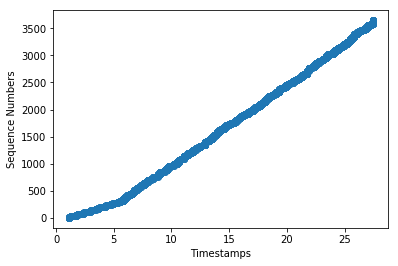

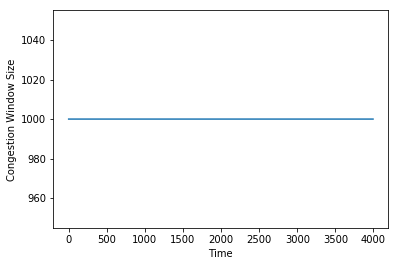

In [11]:
# Test of multiple senders


mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [FixedWindowSender(1000, port)])

[sender] Connected to receiver: 100.64.0.4:53287

Results for sender 50764:
Total Acks: 25874
Num Duplicate Acks: 30
% duplicate acks: 0.115947
Total bytes sent: 1826747
Throughput (bytes/s): 15222.891667
Average RTT (ms): 198.400031


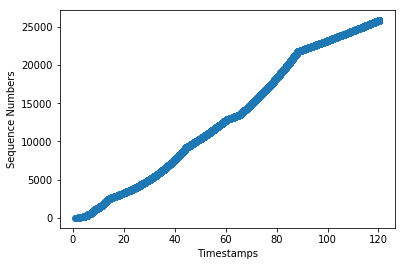

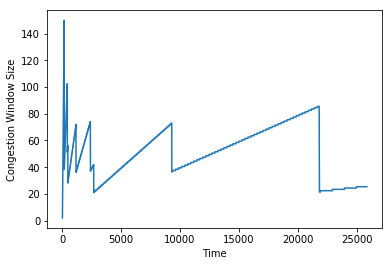

In [12]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [RenoSender(50, 1, port)])


In [13]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [FixedWindowSender(1000, port), FixedWindowSender(1000, port)])


KeyboardInterrupt: 

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [RenoSender(50, 1, port), RenoSender(50, 1, port)])


[sender] Connected to receiver: 100.64.0.2:38257

[sender] Connected to receiver: 100.64.0.2:38257

Results for sender 37342:
Total Acks: 12759
Num Duplicate Acks: 27
% duplicate acks: 0.211615
Total bytes sent: 887771
Throughput (bytes/s): 7398.091667
Average RTT (ms): 196.492768


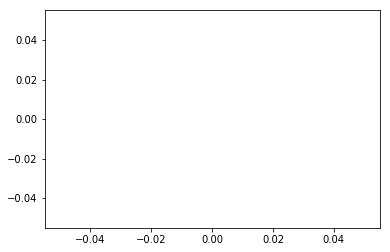

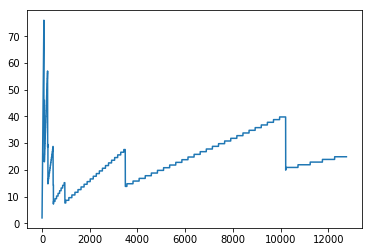


Results for sender 54567:
Total Acks: 16167
Num Duplicate Acks: 30
% duplicate acks: 0.185563
Total bytes sent: 1130369
Throughput (bytes/s): 9419.741667
Average RTT (ms): 196.705268


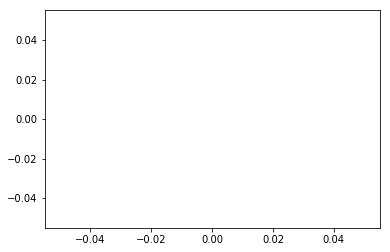

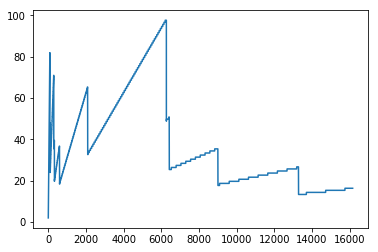

In [12]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [RenoSender(50, 1, port)])


In [36]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [FixedWindowSender(1000, port)])


In [ ]:
mahimahi_settings = {
    'delay': 130,
    'queue_size': 426,
    'trace_file': TRACE_FILES['3.04MBPS']
}

In [ ]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}


In [ ]:
mahimahi_settings = {
    'delay': 45,
    'queue_size': 450,
    'trace_file': TRACE_FILES['114.68MBPS']
}


In [ ]:
# Absurd Queue Size case

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}
